In [1]:
from datetime import datetime
import os
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import tensorflow
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler

In [ ]:
# !pip install pydub

In [ ]:
# !pip install resampy

   ---------------------------------------- 0.0/3.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.1 MB ? eta -:--:--
    --------------------------------------- 0.1/3.1 MB 328.2 kB/s eta 0:00:10
   - -------------------------------------- 0.1/3.1 MB 476.3 kB/s eta 0:00:07
   - -------------------------------------- 0.2/3.1 MB 612.6 kB/s eta 0:00:05
   -- ------------------------------------- 0.2/3.1 MB 737.3 kB/s eta 0:00:04
   -- ------------------------------------- 0.2/3.1 MB 737.3 kB/s eta 0:00:04
   --- ------------------------------------ 0.3/3.1 MB 827.2 kB/s eta 0:00:04
   ---- ----------------------------------- 0.4/3.1 MB 882.8 kB/s eta 0:00:04
   ------ --------------------------------- 0.5/3.1 MB 1.0 MB/s eta 0:00:03
   ------- -------------------------------- 0.6/3.1 MB 1.1 MB/s eta 0:00:03
   ------- -------------------------------- 0.6/3.1 MB 1.1 MB/s eta 0:00:03
   --------- ------

In [ ]:
path = "../Respiratory_Sound_Database/audio_and_txt_files"
filenames = [f for f in listdir(path) if (isfile(join(path, f)) and f.endswith('.wav'))]

In [4]:
# Patient ID corresponding to each file
patient_id_in_file = []

for name in filenames:
    patient_id_in_file.append(int(name[:3]))
    
patient_id_in_file = np.array(patient_id_in_file)

In [5]:
filepaths = [join(path, f) for f in filenames]

In [ ]:
p_diag = pd.read_csv("../Respiratory_Sound_Database/patient_diagnosis.csv", header=None)

In [7]:
print(p_diag.head())
print(p_diag.shape)

     0        1
0  101     URTI
1  102  Healthy
2  103   Asthma
3  104     COPD
4  105     URTI
(126, 2)


In [8]:
# labels for audio files
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in patient_id_in_file])

### Data Augmentation Functions

In [9]:
# NOISE
def add_noise(data):
    noise_value = 0.015 * np.random.uniform() * np.amax(data)
    data = data + noise_value * np.random.normal(size=data.shape[0])
    return data

In [10]:
# STRETCH
def stretch_process(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)

In [11]:
# PITCH
def pitch_process(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

### Data Process Functions

In [12]:
# Extract Features
def extract_process(data, sample_rate):
    output_result = np.array([])
    mean_zero = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    output_result = np.hstack((output_result, mean_zero))
    stft_out = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft_out, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, chroma_stft))

    mfcc_out = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    output_result = np.hstack((output_result, mfcc_out))

    root_mean_out = np.mean(librosa.feature.rms(y=data).T, axis=0)
    output_result = np.hstack((output_result, root_mean_out))

    mel_spectogram = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, mel_spectogram))

    return output_result

In [13]:
# Export Features
def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=42, offset=0.6)

        # Extract features from the original audio data
        extracted_features = extract_process(audio, sample_rate)
        result = np.array(extracted_features)

        # Add noise and extract features
        noise_out = add_noise(audio)
        output_2 = extract_process(noise_out, sample_rate)
        result = np.vstack((result, output_2))

        # Time-stretch and then pitch-shift before extracting features
        new_out = stretch_process(audio,0.8)
        stretch_pitch = pitch_process(new_out, sample_rate,pitch_factor=0.7)
        output_3 = extract_process(stretch_pitch, sample_rate)
        result = np.vstack((result, output_3))

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print("Error Details:", e)
        return None

    return result

### Data Process and Engineering

In [14]:
import resampy
import pydub

print(resampy.__version__)

0.4.3


c:\Users\AfwaAfini\.conda\envs\hacktiv8-python\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [15]:
# Transformation and Exportation
features = []

# Iterate through each sound file and extract the features
for file_name in tqdm(filepaths, desc='Extracting features'):
    data = extract_features(file_name)
    features.append(data)
    
print("Finished feature extraction from ", len(features), " files")
features = np.array(features)

Extracting features:   0%|          | 3/920 [00:39<2:40:58, 10.53s/it]c:\Users\AfwaAfini\.conda\envs\hacktiv8-python\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Extracting features: 100%|██████████| 920/920 [34:57<00:00,  2.28s/it]  

Finished feature extraction from  920  files


____

In [16]:
from collections import Counter

print(Counter(labels))

Counter({'COPD': 793, 'Pneumonia': 37, 'Healthy': 35, 'URTI': 23, 'Bronchiectasis': 16, 'Bronchiolitis': 13, 'LRTI': 2, 'Asthma': 1})


In [17]:
# Delete the very rare diseases
new_features = np.delete(features, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

new_labels = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

In [18]:
# new_labels class counts
unique_elements, counts_elements = np.unique(new_labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
 ['16' '13' '793' '35' '37' '23']]


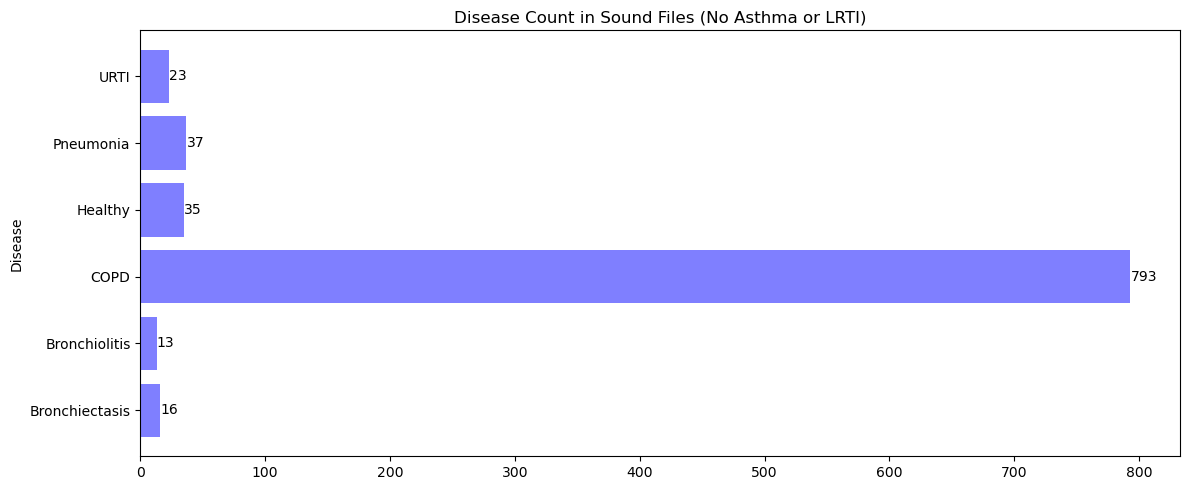

In [19]:
# Plotting
plt.figure(figsize=(12, 5))
plt.barh(unique_elements, counts_elements, align='center', alpha=0.5, color='blue')

for i, v, in enumerate(counts_elements):
    plt.text(v + 0.2, i, str(v), va='center')
    
plt.ylabel('Disease')
plt.title('Disease Count in Sound Files (No Asthma or LRTI)')
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

___

In [20]:
# Flattened features array for preparing 1D CNN Model
flattened_features = new_features.reshape(-1, 182)

In [21]:
augmented_labels = np.repeat(labels, 3)

In [22]:
augmented_features = np.reshape(features, (-1, 182))

# Flatten the feature sets
mask = ~np.isin(augmented_labels, ['Asthma', 'LRTI'])
augmented_features = augmented_features[mask]
augmented_labels = augmented_labels[mask]

In [23]:
unique_values = set(augmented_labels)
unique_values

{'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI'}

In [24]:
le = LabelEncoder()
i_labels = le.fit_transform(augmented_labels)
oh_labels = to_categorical(i_labels)

In [25]:
oh_labels

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [26]:
original_labels = le.inverse_transform(i_labels)
original_labels

array(['URTI', 'URTI', 'URTI', ..., 'Pneumonia', 'Pneumonia', 'Pneumonia'],
      dtype='<U14')

In [27]:
flattened_features.shape

(2751, 182)

____

In [28]:
# Train Test Split
x_train, x_test, y_train, y_test = train_test_split(flattened_features, oh_labels, stratify=oh_labels, test_size=0.2, random_state=42)

In [1]:
flattened_features

NameError: name 'flattened_features' is not defined

In [29]:
# Scaler & Transformation
scaler_data = StandardScaler()

In [30]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2200, 182)
(2200, 6)
(551, 182)
(551, 6)


In [31]:
x_train = scaler_data.fit_transform(x_train)
x_test = scaler_data.transform(x_test)

In [32]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

### Model

In [33]:
# Determine the number of unique classes
num_labels = len(np.unique(new_labels))

Model = Sequential([
    layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(units=32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(units=num_labels, activation='softmax')
])

c:\Users\AfwaAfini\.conda\envs\hacktiv8-python\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor="loss", patience=3, mode="min")

In [36]:
evConv1D_Model = Model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 237ms/step - accuracy: 0.7461 - loss: 1.0581 - val_accuracy: 0.8639 - val_loss: 0.6083
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - accuracy: 0.8631 - loss: 0.6771 - val_accuracy: 0.8639 - val_loss: 0.5494
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.8626 - loss: 0.5715 - val_accuracy: 0.8639 - val_loss: 0.5041
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.8822 - loss: 0.4873 - val_accuracy: 0.8639 - val_loss: 0.4947
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.8607 - loss: 0.5055 - val_accuracy: 0.8639 - val_loss: 0.4515
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.8708 - loss: 0.4326 - val_accuracy: 0.8675 - val_loss: 0.4099
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - accuracy: 0.8685 - loss: 0.4102 - val_accuracy: 0.8784 - val_loss: 0.3935
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.8773 - loss: 0.3943 - val_accuracy: 

In [37]:
Model_Results = Model.evaluate(x_test, y_test)
print("LOSS: " + "%.4f" % Model_Results[0])
print("ACCURACY: " + "%.4f" % Model_Results[1])

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9010 - loss: 0.3724
LOSS: 0.3743
ACCURACY: 0.8966


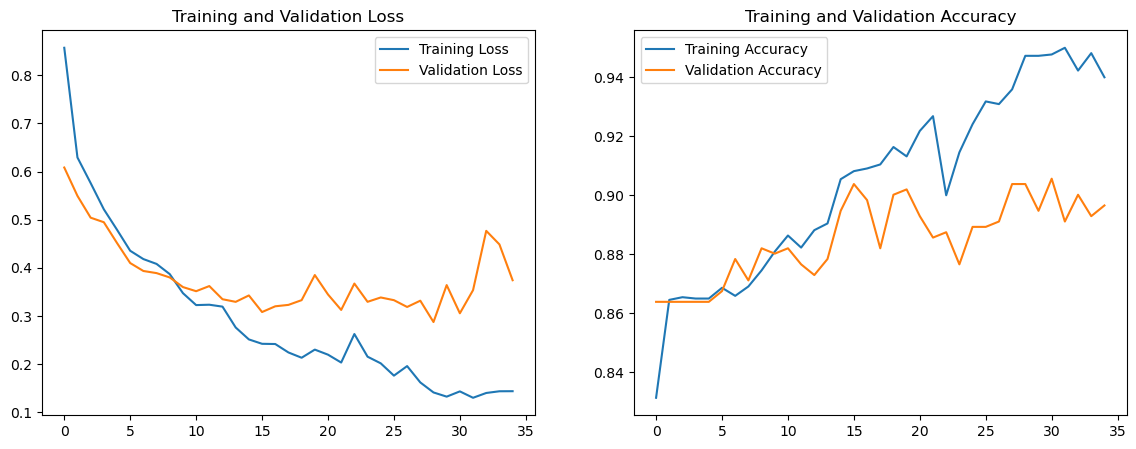

In [38]:
# Plotting loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(evConv1D_Model.history['loss'], label='Training Loss')
plt.plot(evConv1D_Model.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(evConv1D_Model.history['accuracy'], label='Training Accuracy')
plt.plot(evConv1D_Model.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

____

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


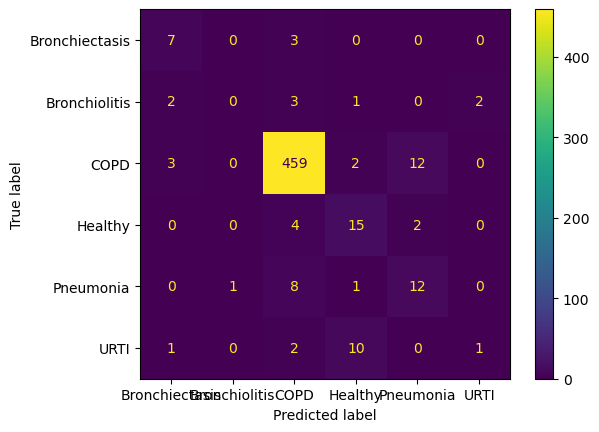

In [39]:
# Confusion Matrix
# Getting the predictions
y_pred = Model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

confusion_mtx = confusion_matrix(y_true, y_pred_classes)
cm_display = ConfusionMatrixDisplay(confusion_mtx, display_labels=le.classes_).plot()

In [40]:
def predict(x_test):
    y_pred = Model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    mapping = {
        0: 'Bronchiectasis',
        1: 'Brinchiolitis',
        2: 'COPD',
        3: 'Healthy',
        4: 'Pneumonia',
        5: 'URTI'
    }
    
    # replace numerical labels with original labels
    predictions = [mapping[label] for label in y_pred_classes]
    accuracy = accuracy_score(y_true, y_pred_classes)
    print("Test Accuracy:", accuracy)
    
    return predictions

In [41]:
predict(x_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Test Accuracy: 0.896551724137931


['COPD',
 'COPD',
 'Pneumonia',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'Bronchiectasis',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'Pneumonia',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'Bronchiectasis',
 'COPD',
 'COPD',
 'COPD',
 'Healthy',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'Bronchiectasis',
 'COPD',
 'COPD',
 'COPD',
 'Healthy',
 'COPD',
 'COPD',
 'COPD',
 'Healthy',
 'COPD',
 'Healthy',
 'COPD',
 'URTI',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'Healthy',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'Pneumonia',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'Healthy',
 'COPD',
 'Pneumonia',
 'Pneumonia',
 'COPD',
 'COPD',
 'COPD',
 'Healthy',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD

In [ ]:
model_path = "D:\model-respiratory diagnosis"

if not os.path.exists(model_path):
    os.makedirs(model_path)
    
Model.save(os.path.join(model_path, "v1-model.h5"))

print("Model saved successfully")
print(os.path.join(model_path, "v1-model.h5"))

Model saved successfully
D:\model-respiratory diagnosis\v1-model.h5


In [43]:
Model.save('v1-disease-predict.keras')